Допустим, у нас есть следующие данные для обучения модели:

Количество запросов по каждому эндпоинту
Время выполнения запроса для каждого эндпоинта
Количество обрабатываемых в настоящий момент запросов каждым эндпоинтом
Поля запроса

время выполнения запроса = константа + a * количество запросов за квант времени +  c * количество обрабатываемых запросов




Для сбора трейсов создаем два микросервиса
Первый запускает указанное количество параллельных запросов на второй, поведение которого нас интересует

# 1. Подготовка данных

Выгружаем логи из Kibana и формируем датасет

In [74]:
import pandas as pd

In [75]:
data = pd.read_csv('dataset.csv', sep = ',')

In [76]:
data.head()

,_id,_index,_score,_type,duration,flags,logs,operationName,process.serviceName,process.tags,references,spanID,startTime,startTimeMillis,tags,traceID
0,jj-OQYcBJPdS4Lm3m1lG,jaeger-span-2023-04-02,NaN,_doc,"26,527,144",1,[],/generate_image,microservice1,[],"[{""refType"":""CHILD_OF"",""traceID"":""7a24b2de56c1...",dc3da4088b1fc504,"1,680,432,050,219,714","Apr 2, 2023 @ 10:40:50.219","[{""key"":""http.method"",""type"":""string"",""value"":...",7a24b2de56c17ccc35a2a4b6f737ad71
1,bj-OQYcBJPdS4Lm3N1lF,jaeger-span-2023-04-02,NaN,_doc,"1,877,006",1,[],/generate_image,microservice1,[],"[{""refType"":""CHILD_OF"",""traceID"":""984de8f38cff...",e2f60354dd5b271d,"1,680,432,048,480,591.75","Apr 2, 2023 @ 10:40:48.480","[{""key"":""http.method"",""type"":""string"",""value"":...",984de8f38cff7f8817280a52d9b41245
2,gz-OQYcBJPdS4Lm3dFk1,jaeger-span-2023-04-02,NaN,_doc,"21,175,829",1,[],/generate_image,microservice1,[],"[{""refType"":""CHILD_OF"",""traceID"":""9200aca905cf...",ea3aabc688f0bf3c,"1,680,432,042,377,615","Apr 2, 2023 @ 10:40:42.377","[{""key"":""http.method"",""type"":""string"",""value"":...",9200aca905cf28a6c85d3153096b2bb4
3,aj-OQYcBJPdS4Lm3N1lF,jaeger-span-2023-04-02,NaN,_doc,"10,878,760",1,[],/generate_image,microservice1,[],"[{""refType"":""CHILD_OF"",""traceID"":""67a4d9fb450e...",3ed0f519689f626e,"1,680,432,038,078,404","Apr 2, 2023 @ 10:40:38.078","[{""key"":""http.method"",""type"":""string"",""value"":...",67a4d9fb450ea0fe2f8ad5d349b63a43
4,bz-OQYcBJPdS4Lm3N1lF,jaeger-span-2023-04-02,NaN,_doc,"11,557,708",1,[],/generate_image,microservice1,[],"[{""refType"":""CHILD_OF"",""traceID"":""c9c4a08d20ed...",1140104a21969f26,"1,680,432,037,041,813","Apr 2, 2023 @ 10:40:37.041","[{""key"":""http.method"",""type"":""string"",""value"":...",c9c4a08d20ed2c711585d4773dd52269


Теперь необходимо преобразовать данные в нужный формат.

Сначала необходимо извлечь из столбца ***tags*** данные о запросе - эндпоинт и параметры запроса 

In [77]:
import re
def get_endpoint_data(data):
    pattern = pattern = r'"key":"http.target","type":"string","value":"([^"]+)"'
    match = re.search(pattern, data)
    if match:
        url = match.group(1)
        return match.group(1)
    else:
        print('Value not found.')
    

In [78]:
data['endpoint'] = data['tags'].apply(get_endpoint_data)

Удаляем ненужные столбцы

In [79]:
data.drop(['_id','_index','_score','_type','flags','logs','operationName', 'process.tags','process.serviceName','spanID', 'tags', 'traceID', 'references'], axis=1, inplace=True)
data.head()

,duration,startTime,startTimeMillis,endpoint
0,"26,527,144","1,680,432,050,219,714","Apr 2, 2023 @ 10:40:50.219",/generate_image?x=113&y=124&additional=three
1,"1,877,006","1,680,432,048,480,591.75","Apr 2, 2023 @ 10:40:48.480",/generate_image?x=151&y=53
2,"21,175,829","1,680,432,042,377,615","Apr 2, 2023 @ 10:40:42.377",/generate_image?x=144&y=147&additional=two
3,"10,878,760","1,680,432,038,078,404","Apr 2, 2023 @ 10:40:38.078",/generate_image?x=261&y=162
4,"11,557,708","1,680,432,037,041,813","Apr 2, 2023 @ 10:40:37.041",/generate_image?x=272&y=280


Теперь необходимо извлечь параметры из столбца ***endpoint*** нужно извлечь параметры и добавить в датасет столбцы с их названием и присвоить им их значения. Если значение параметра — строка, применяем *one hot encoding*

In [80]:
# Регулярное выражение для извлечения параметров запроса и их значений
pattern = r'\?([^#]*)'

# Извлечение пути запроса и параметров
params = data['endpoint'].apply(lambda x: re.search(pattern, x).group(1))

# Создание списка параметров запроса
param_names = []
for param in params:
    param_list = param.split('&')
    for p in param_list:
        name, value = p.split('=')
        if name not in param_names:
            param_names.append(name)

In [81]:
# Извлеченные названия параметров
param_names

['x', 'y', 'additional']

In [82]:
# Создание нового датафрейма для параметров запроса
df = None
params_df=None
params_df = pd.DataFrame(columns=param_names)
for i, param in enumerate(params):
    param_list = param.split('&')
    param_values = {}
    for p in param_list:
        name, value = p.split('=')
        #param_values[name] = value
        try:
            param_values[name] = int(value)
        except:
            if isinstance(value, str):
                param_values[name+'_'+value] = 1
    df = pd.concat([df, pd.DataFrame.from_records([param_values])])

In [83]:
df = df.reset_index(drop=True)
df.fillna(0, inplace=True)
df.head()

,x,y,additional_three,additional_two,additional_one
0,113,124,1.0,0.0,0.0
1,151,53,0.0,0.0,0.0
2,144,147,0.0,1.0,0.0
3,261,162,0.0,0.0,0.0
4,272,280,0.0,0.0,0.0


In [84]:
# Объединяем датафреймы
data = pd.merge(data, df, left_index=True, right_index=True)
data.head()

,duration,startTime,startTimeMillis,endpoint,x,y,additional_three,additional_two,additional_one
0,"26,527,144","1,680,432,050,219,714","Apr 2, 2023 @ 10:40:50.219",/generate_image?x=113&y=124&additional=three,113,124,1.0,0.0,0.0
1,"1,877,006","1,680,432,048,480,591.75","Apr 2, 2023 @ 10:40:48.480",/generate_image?x=151&y=53,151,53,0.0,0.0,0.0
2,"21,175,829","1,680,432,042,377,615","Apr 2, 2023 @ 10:40:42.377",/generate_image?x=144&y=147&additional=two,144,147,0.0,1.0,0.0
3,"10,878,760","1,680,432,038,078,404","Apr 2, 2023 @ 10:40:38.078",/generate_image?x=261&y=162,261,162,0.0,0.0,0.0
4,"11,557,708","1,680,432,037,041,813","Apr 2, 2023 @ 10:40:37.041",/generate_image?x=272&y=280,272,280,0.0,0.0,0.0


Теперь преобразуем значения столбцов со временем и удалим лишние столбцы

In [85]:
# Преобразуем значение из логов в количество миллисекунд
def transform_time(s):
    items = s.split(',')
    
    # Возвращаем без миллионнных долей секунды
    return ''.join(items[:-1])

data['starttime_m'] = data['startTime'].apply(transform_time)
data['duration_m'] = data['duration'].apply(transform_time)

In [86]:
data.head()

,duration,startTime,startTimeMillis,endpoint,x,y,additional_three,additional_two,additional_one,starttime_m,duration_m
0,"26,527,144","1,680,432,050,219,714","Apr 2, 2023 @ 10:40:50.219",/generate_image?x=113&y=124&additional=three,113,124,1.0,0.0,0.0,1680432050219,26527
1,"1,877,006","1,680,432,048,480,591.75","Apr 2, 2023 @ 10:40:48.480",/generate_image?x=151&y=53,151,53,0.0,0.0,0.0,1680432048480,1877
2,"21,175,829","1,680,432,042,377,615","Apr 2, 2023 @ 10:40:42.377",/generate_image?x=144&y=147&additional=two,144,147,0.0,1.0,0.0,1680432042377,21175
3,"10,878,760","1,680,432,038,078,404","Apr 2, 2023 @ 10:40:38.078",/generate_image?x=261&y=162,261,162,0.0,0.0,0.0,1680432038078,10878
4,"11,557,708","1,680,432,037,041,813","Apr 2, 2023 @ 10:40:37.041",/generate_image?x=272&y=280,272,280,0.0,0.0,0.0,1680432037041,11557


In [89]:
import numpy as np
data['duration_m'] = data['duration_m'].astype(np.int64)
data['starttime_m'] = data['starttime_m'].astype(np.int64)
print(data.dtypes)

duration                      object
startTime                     object
startTimeMillis               object
endpoint                      object
x                              int64
y                              int64
additional_three             float64
additional_two               float64
additional_one               float64
starttime_m                    int64
duration_m                     int64
start                 datetime64[ns]
end                   datetime64[ns]
parallel_processes             int64
dtype: object


In [90]:
#  Преобразование столбца starttime_m в формат datetime
data['starttime_m'] = pd.to_datetime(data['starttime_m'], unit='ms')

# Сортировка датафрейма по starttime_m
data = data.sort_values(by=['starttime_m'])

# Создание столбцов start и end
data['start'] = data['starttime_m']
data['end'] = data['start'] + pd.to_timedelta(data['duration_m'], unit='ms')

# Создание столбца parallel_processes
parallel_processes = []
for i in range(len(data)):
    start = data.iloc[i]['start']
    end = data.iloc[i]['end']
    parallel = len(data[(data['start'] <= start) & (data['end'] > start) | (data['start'] < end) & (data['end'] >= end)])
    parallel_processes.append(parallel)
data['parallel_processes'] = parallel_processes

OutOfBoundsDatetime: cannot convert input with unit 'ms'

Удаляем лишние столбцы и получаем готовый датасет

In [91]:
data.drop(['duration', 'startTime','startTimeMillis', 'starttime_m', 'start', 'end', 'endpoint'], axis=1, inplace=True)
data.to_csv('dataset_final.csv', index=False)
data.head()


,x,y,additional_three,additional_two,additional_one,duration_m,parallel_processes
1130,200,200,0.0,0.0,0.0,3373,1
1129,150,300,0.0,0.0,0.0,3390,1
1128,150,300,0.0,0.0,0.0,3972,1
1127,152,350,0.0,0.0,0.0,4023,1
1126,152,350,0.0,0.0,0.0,2947,1


# 2. Обучение модели

Используем линейную регрессию из библиотеки scikit-learn. Данные подготавливаются путем разбиения на тренировочный и тестовый наборы, а затем модель обучается на тренировочных данных. После этого мы можем использовать обученную модель для предсказания продолжительности на тестовых данных и оценки качества модели с помощью коэффициента детерминации (R^2 score).

In [92]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [93]:
X = data[['x', 'y', 'additional_three', 'additional_two', 'additional_one', 'parallel_processes']]
y = data['duration_m']

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [95]:
# Создание и обучение модели
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [96]:
# Предсказание на тестовых данных
y_pred = model.predict(X_test)

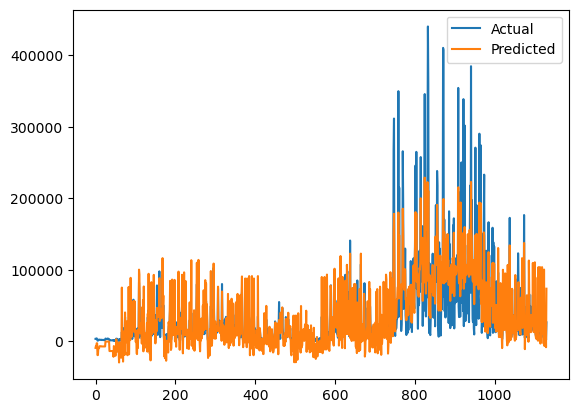

In [97]:
# построение графика обучения модели
plt.plot(range(len(y)), y, label='Actual')
plt.plot(range(len(y)), model.predict(X), label='Predicted')
plt.legend()
plt.show()

Как видим, модель не очень хорошо справляется с выбросами

In [98]:
# Оценка качества модели
r2 = r2_score(y_test, y_pred)
print('R^2 score:', r2)

R^2 score: 0.6794454033531004


In [99]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

Intercept: 9934.63036273377
Coefficients: [-1.94236548e-09 -6.04391491e+01 -5.62002346e+01 -9.15104068e+03
 -5.18208022e+03  7.15086445e+03 -1.10067337e+03  3.12264719e-02
  2.49571634e-01  1.14754963e+01  4.87474797e+01 -1.86880187e+01
  9.16333201e+00 -3.49238237e-03  1.26647826e+02  4.21423094e+01
 -1.86304904e+01  9.52243289e+00 -9.15104068e+03  2.72848411e-12
  2.72848411e-12  6.82768704e+03 -5.18208022e+03  0.00000000e+00
  3.72623568e+03  7.15086445e+03  1.37571769e+03 -1.76492336e+01]


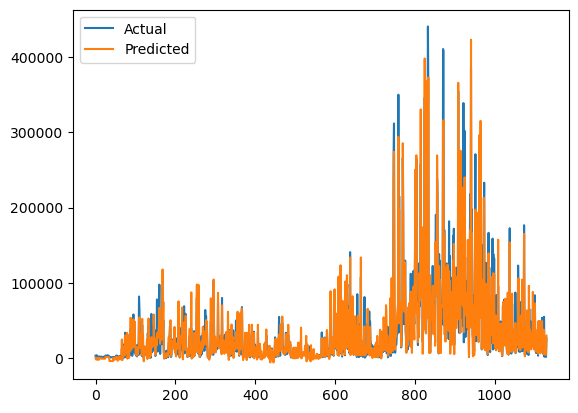

R^2 score: 0.8735650705020729


In [100]:
# Создаем объект для преобразования данных
poly = PolynomialFeatures(degree=2)

# Преобразуем признаки
X_poly = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# построение графика обучения модели
plt.plot(range(len(y)), y, label='Actual')
plt.plot(range(len(y)), model.predict(X_poly), label='Predicted')
plt.legend()
plt.show()

r2 = r2_score(y_test, y_pred)
print('R^2 score:', r2)

При использовании  полиномиального преобразования точность выросла